seed アンサンブル, epoch weightingはめっちゃ効く

lossはlastの方が低くていいけど, w_aucはepoch_weighingの方がいい。 lossとauc完全に関係してるわけじゃないしね。

confidenceでfilterするのは無理そう。confidenceが高いとこで, bpsnがめっちゃ下がるから。subgroup => toxicってしちゃってる。

In [1]:
import numpy as np
import pandas as pd
import os
import time
import gc
import random
from contextlib import contextmanager
from fastprogress import master_bar, progress_bar
from keras.preprocessing import text, sequence
import torch
from torch import nn
from torch.utils import data
from torch.nn import functional as F
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [213]:
NUM_MODELS = 2
LSTM_UNITS = 128
DENSE_HIDDEN_UNITS = 2 * LSTM_UNITS
MAX_LEN = 220
batch_size = 512
n_seeds = 2
n_splits = 5
n_epochs = 10


In [3]:
@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')

In [4]:
import joblib

In [5]:
%%time
with open('../input/crawl_emb_processed.joblib', 'rb') as f:
    crawl_emb_dict = joblib.load(f)

CPU times: user 1min 22s, sys: 2.71 s, total: 1min 24s
Wall time: 1min 26s


In [6]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [7]:
import re
# これだと、'はembeddingに結構入ってるのに除外されちゃう。　よくないので ' だけ抜いた
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

def clean_text(x: str) -> str:
    for punct in puncts:
        if punct in x:
            x = x.replace(punct, ' {} '.format(punct))
    return x

In [64]:
%%time
# 9.9G
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

x_train = train['comment_text'].apply(lambda x: clean_text(x))
y_train = np.where(train['target'] >= 0.5, 1, 0)
y_aux_train = train[['target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']]
x_test = test['comment_text'].apply(lambda x: clean_text(x))
del test
gc.collect()

CPU times: user 21.1 s, sys: 703 ms, total: 21.8 s
Wall time: 23.1 s


In [106]:
y_aux_train.mean()

target             0.103017
severe_toxicity    0.004582
obscene            0.013877
identity_attack    0.022636
insult             0.081153
threat             0.009311
dtype: float64

In [107]:
x_train.shape, y_train.shape, y_aux_train.shape, x_test.shape

((1804874,), (1804874,), (1804874, 6), (97320,))

In [108]:
%%time
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(list(x_train) + list(x_test))

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)
x_train = sequence.pad_sequences(x_train, maxlen=MAX_LEN)
x_test = sequence.pad_sequences(x_test, maxlen=MAX_LEN)

CPU times: user 2min 18s, sys: 430 ms, total: 2min 19s
Wall time: 2min 19s


In [109]:
max_features = len(tokenizer.word_index) + 1
max_features

378798

In [110]:
def build_matrix(word_index, embedding_dict):
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    unknown_words = []
    
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embedding_dict[word]
        except KeyError:
            unknown_words.append(word)
    return embedding_matrix, unknown_words


In [111]:
%%time
emb_mat_crawl, oov = build_matrix(tokenizer.word_index, crawl_emb_dict)

NameError: name 'crawl_emb_dict' is not defined

In [112]:
del crawl_emb_dict
gc.collect()

NameError: name 'crawl_emb_dict' is not defined

In [114]:
emb_mat_crawl.shape

(378798, 300)

In [115]:
# Kernelでは17414とか
len(oov)

142880

In [116]:
class SpatialDropout(nn.Dropout2d):
    def forward(self, x):
        x = x.unsqueeze(2)    # (N, T, 1, K)
        x = x.permute(0, 3, 2, 1)  # (N, K, 1, T)
        x = super(SpatialDropout, self).forward(x)  # (N, K, 1, T), some features are masked
        x = x.permute(0, 3, 2, 1)  # (N, T, 1, K)
        x = x.squeeze(2)  # (N, T, K)
        return x
    
class NeuralNet(nn.Module):
    def __init__(self, embedding_matrix, num_aux_targets):
        super(NeuralNet, self).__init__()
        embed_size = embedding_matrix.shape[1]
        
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.embedding_dropout = SpatialDropout(0.3)
        
        self.lstm1 = nn.LSTM(embed_size, LSTM_UNITS, bidirectional=True, batch_first=True)
        self.linear1 = nn.Linear(DENSE_HIDDEN_UNITS, DENSE_HIDDEN_UNITS)
        
        self.linear_out = nn.Linear(DENSE_HIDDEN_UNITS, 1)
        self.linear_aux_out = nn.Linear(DENSE_HIDDEN_UNITS, num_aux_targets)
        
    def forward(self, x):
        h_embedding = self.embedding(x)
        h_embedding = self.embedding_dropout(h_embedding)
        
        h_lstm1, _ = self.lstm1(h_embedding)
        
        # global max pooling
        max_pool, _ = torch.max(h_lstm1, 1)
        
        h_conc_linear1  = F.relu(self.linear1(max_pool))
        
        hidden = max_pool + h_conc_linear1
        
        result = self.linear_out(hidden)
        aux_result = self.linear_aux_out(hidden)
        out = torch.cat([result, aux_result], 1)
        
        return out

In [117]:
gc.collect()
torch.cuda.empty_cache()
torch.cuda.memory_allocated()

7066952192

In [118]:
x_train[:100]

array([[     0,      0,      0, ...,    365,     95,    220],
       [     0,      0,      0, ...,      7,     35,     96],
       [     0,      0,      0, ...,     16,    101,   5011],
       ...,
       [     0,      0,      0, ...,      2,     15, 138727],
       [     0,      0,      0, ...,   1884,    101,   2266],
       [     0,      0,      0, ...,      2,  25186,  55286]], dtype=int32)

In [241]:
x_train_torch = torch.tensor(x_train, dtype=torch.long)
x_test_torch = torch.tensor(x_test, dtype=torch.long)
y_train_torch = torch.tensor(np.hstack([y_train[:, np.newaxis], y_aux_train]), dtype=torch.float32)

In [248]:
gc.collect()
torch.cuda.empty_cache()
torch.cuda.memory_allocated()

3652800512

In [238]:
del x_train_torch, x_test_torch, y_train_torch

In [230]:
gc.collect()
torch.cuda.empty_cache()

In [227]:
del model

In [245]:
del dev_loader, val_loader

NameError: name 'dev_loader' is not defined

In [246]:
del dev_dataset, val_dataset, dev_loader, val_loader, model, test_dataset, test_loader
gc.collect()
torch.cuda.empty_cache()

NameError: name 'dev_dataset' is not defined

In [247]:
del test_dataset, test_loader

In [127]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [165]:
OOF_TRAIN_COL = 'oof_train'
SUBGROUP_AUC_COL = 'subgroup_auc'
BPSN_AUC_COL = 'bpsn_auc'  # stands for background positive, subgroup negative
BNSP_AUC_COL = 'bnsp_auc'  # stands for background negative, subgroup positive
from sklearn import metrics
def compute_auc(y_true, y_pred):
    try:
        return metrics.roc_auc_score(y_true, y_pred)
    except ValueError:
        return np.nan

def compute_subgroup_auc(df, subgroup_col, label_col, oof_col):
    subgroup_examples = df[df[subgroup_col]]
    return compute_auc(subgroup_examples[label_col], subgroup_examples[oof_col])

def compute_bpsn_auc(df, subgroup_col, label_col, oof_col):
    """Computes the AUC of the within-subgroup negative examples and the background positive examples."""
    subgroup_negative_examples = df[df[subgroup_col] & ~df[label_col]]
    non_subgroup_positive_examples = df[~df[subgroup_col] & df[label_col]]
    examples = subgroup_negative_examples.append(non_subgroup_positive_examples)
    return compute_auc(examples[label_col], examples[oof_col])

def compute_bnsp_auc(df, subgroup_col, label_col, oof_col):
    """Computes the AUC of the within-subgroup positive examples and the background negative examples."""
    subgroup_positive_examples = df[df[subgroup_col] & df[label_col]]
    non_subgroup_negative_examples = df[~df[subgroup_col] & ~df[label_col]]
    examples = subgroup_positive_examples.append(non_subgroup_negative_examples)
    return compute_auc(examples[label_col], examples[oof_col])

def compute_bias_metrics_for_model(df,
                                   subgroup_list,
                                   oof_col,
                                   label_col,
                                   include_asegs=False):
    """Computes per-subgroup metrics for all subgroups and one model."""
    record_list = []
    for subgroup in subgroup_list:
        record = {
            'subgroup': subgroup,
            'subgroup_size': len(df[df[subgroup]])
        }
        record[SUBGROUP_AUC_COL] = compute_subgroup_auc(df, subgroup, label_col, oof_col)
        record[BPSN_AUC_COL] = compute_bpsn_auc(df, subgroup, label_col, oof_col)
        record[BNSP_AUC_COL] = compute_bnsp_auc(df, subgroup, label_col, oof_col)
        record_list.append(record)
    return pd.DataFrame(record_list).sort_values('subgroup_auc', ascending=True)

TOXICITY_COLUMN = 'target'
identity_columns = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']
# Convert taget and identity columns to booleans
def convert_to_bool(df, col_name):
    df[col_name] = np.where(df[col_name] >= 0.5, True, False)
    
def convert_dataframe_to_bool(df):
    bool_df = df.copy()
    for col in ['target'] + identity_columns:
        convert_to_bool(bool_df, col)
    return bool_df

def calculate_overall_auc(df, model_name):
    true_labels = df[TOXICITY_COLUMN]
    predicted_labels = df[model_name]
    return metrics.roc_auc_score(true_labels, predicted_labels)

def power_mean(series, p):
    total = sum(np.power(series, p))
    return np.power(total / len(series), 1 / p)

def get_final_metric(bias_df, overall_auc, POWER=-5, OVERALL_MODEL_WEIGHT=0.25):
    bias_score = np.average([
        power_mean(bias_df[SUBGROUP_AUC_COL], POWER),
        power_mean(bias_df[BPSN_AUC_COL], POWER),
        power_mean(bias_df[BNSP_AUC_COL], POWER)
    ])
    return (OVERALL_MODEL_WEIGHT * overall_auc) + ((1 - OVERALL_MODEL_WEIGHT) * bias_score)

def get_various_auc(valid_df, y_pred):
    valid_df = convert_dataframe_to_bool(valid_df.fillna(0))
    valid_df.loc[:, OOF_TRAIN_COL] = y_pred
    valid_df = convert_dataframe_to_bool(valid_df.fillna(0))
    bias_metrics_df = compute_bias_metrics_for_model(valid_df, identity_columns, OOF_TRAIN_COL, TOXICITY_COLUMN)
    overall_auc = calculate_overall_auc(valid_df, OOF_TRAIN_COL)
    return get_final_metric(bias_metrics_df, overall_auc), overall_auc, bias_metrics_df

In [220]:
y_train_torch[dev_index].mean().item(), y_train_torch[val_index].mean().item()

(0.03489391878247261, 0.035473331809043884)

In [249]:
debug = False
DEBUG_DATA_SIZE = 10000
if debug:
    x_train_torch = x_train_torch[:DEBUG_DATA_SIZE]
    x_test_torch = x_test_torch[:DEBUG_DATA_SIZE]
    y_train_torch = y_train_torch[:DEBUG_DATA_SIZE]

loss_fn=nn.BCEWithLogitsLoss(reduction='mean')
embedding_matrix = emb_mat_crawl

test_dataset = data.TensorDataset(x_test_torch.cuda())
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False)

checkpoint_weights = [2 ** epoch for epoch in range(n_epochs)]
checkpoint_weights = np.array(checkpoint_weights) / np.sum(checkpoint_weights)

dev_loss_array = np.zeros((n_seeds, n_splits, n_epochs))
val_loss_array = np.zeros((n_seeds, n_splits, n_epochs))

auc_array = np.zeros((n_seeds, n_splits, n_epochs))

seed_oof_train_epoch_weighted_list = []
seed_oof_train_last_list = []

from sklearn.model_selection import KFold
kf = KFold(n_splits=n_splits, shuffle=True)
for i_seed in range(n_seeds):
    print(f'start seed {i_seed}')
    
    fold_dev_loss_list = []
    fold_val_loss_list = []
    oof_train_epoch_weighted = np.zeros(x_train_torch.size()[0])
    oof_train_last = np.zeros(x_train_torch.size()[0])
    
    for i_fold, (dev_index, val_index) in enumerate(kf.split(x_train_torch)):
        print(f'start fold {i_fold}')
        print(f'toxic ratio dev: {y_train_torch[dev_index].mean().item()}, val: {y_train_torch[val_index].mean().item()}')
        model = NeuralNet(embedding_matrix, y_aux_train.shape[-1])
        model.cuda()
        print(torch.cuda.memory_allocated())

        optimizer = torch.optim.Adam(model.parameters())

        dev_dataset = data.TensorDataset(x_train_torch[dev_index].cuda(), y_train_torch[dev_index].cuda())
        val_dataset = data.TensorDataset(x_train_torch[val_index].cuda(), y_train_torch[val_index].cuda())

        dev_loader = torch.utils.data.DataLoader(
            dev_dataset, batch_size=batch_size, shuffle=True)
        val_loader = torch.utils.data.DataLoader(
            val_dataset, batch_size=batch_size, shuffle=False)
        
        print(torch.cuda.memory_allocated())
        all_test_preds = []
        mb = master_bar(range(n_epochs))
        dev_loss_list = []
        val_loss_list = []
        weighted_val_pred = np.zeros(val_index.shape[0])

        for i_epoch in mb:
            start_time = time.time() 
            model.train()
            dev_avg_loss = 0.
            for batch in progress_bar(dev_loader):
                x_batch = batch[:-1]
                y_batch = batch[-1]

                y_pred = model(*x_batch)

                loss = loss_fn(y_pred, y_batch)

                optimizer.zero_grad()
                loss.backward()

                optimizer.step()
                dev_avg_loss += loss.item()
            dev_loss_array[i_seed, i_fold, i_epoch] = dev_avg_loss

            model.eval()
            val_avg_loss = 0.
            epoch_val_pred = np.zeros(val_index.shape[0])
            for i_batch, batch in enumerate(progress_bar(val_loader)):
                x_batch = batch[:-1]
                y_batch = batch[-1]

                y_pred = model(*x_batch)

                loss = loss_fn(y_pred, y_batch)
                val_avg_loss += loss.item()
                
                i_start = i_batch * batch_size
                epoch_val_pred[i_start: i_start + y_pred.size()[0]] = sigmoid(y_pred[:, 0].detach().cpu().numpy())
            
            val_loss_array[i_seed, i_fold, i_epoch] = val_avg_loss
            
            weighted_val_pred += epoch_val_pred * checkpoint_weights[i_epoch]
            
            valid_df = train.iloc[val_index]
            weighted_auc, overall_auc, bias_df = get_various_auc(valid_df, epoch_val_pred)
            auc_array[i_seed, i_fold, i_epoch] = weighted_auc
            del valid_df
            gc.collect()
            
            elapsed_time = time.time() - start_time
            mb.write(f'Finished epoch {i_epoch} in {elapsed_time: .0f}, dev_loss: {dev_avg_loss:.4f}, val_loss: {val_avg_loss:.4f}' + \
                     f', weighted_auc: {weighted_auc}, overall_auc: {overall_auc} ')

            
        oof_train_epoch_weighted[val_index] = weighted_val_pred
        oof_train_last[val_index] = epoch_val_pred
        
        fold_dev_loss_list.append(dev_loss_list)
        fold_val_loss_list.append(val_loss_list)
        del dev_dataset, val_dataset, dev_loader, val_loader, model, weighted_val_pred, epoch_val_pred
        gc.collect()
        torch.cuda.empty_cache()

    seed_oof_train_epoch_weighted_list.append(oof_train_epoch_weighted)
    seed_oof_train_last_list.append(oof_train_last)    

start seed 0
start fold 0
toxic ratio dev: 0.04496954753994942, val: 0.044836197048425674
4280906752
7049800704


start fold 1
toxic ratio dev: 0.04496900364756584, val: 0.04483834281563759
4287567872
7056461824


start fold 2
toxic ratio dev: 0.04489311948418617, val: 0.045142125338315964
4287830016
7056723968


start fold 3
toxic ratio dev: 0.04492511600255966, val: 0.045013733208179474
4287830016
7056723968


start fold 4
toxic ratio dev: 0.044968798756599426, val: 0.04483899846673012
4287830016
7056723968


start seed 1
start fold 0
toxic ratio dev: 0.04491756483912468, val: 0.045044440776109695
4287035904
7055929856


start fold 1
toxic ratio dev: 0.044901419430971146, val: 0.045108672231435776
4287830016
7056723968


start fold 2
toxic ratio dev: 0.04494952782988548, val: 0.04491599649190903
4287830016
7056723968


start fold 3
toxic ratio dev: 0.044965945184230804, val: 0.04485055059194565
4287830016
7056723968


start fold 4
toxic ratio dev: 0.044991105794906616, val: 0.044749777764081955
4287830016
7056723968


In [250]:
dev_loss_array.shape

(2, 5, 10)

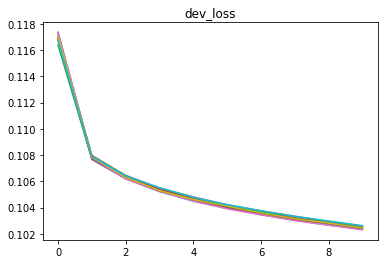

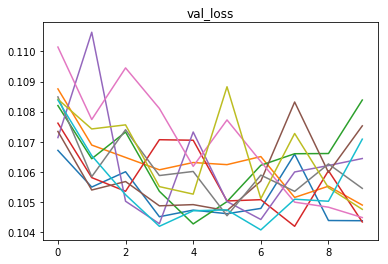

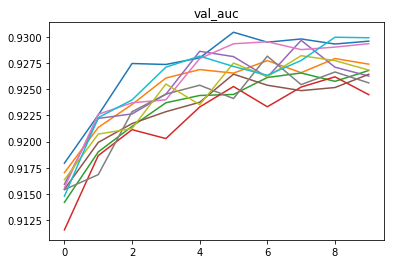

In [251]:
plt.figure()
plt.title('dev_loss')
for i_seed in range(n_seeds):
    for dev_loss in dev_loss_array[i_seed]:
        plt.plot(range(n_epochs), dev_loss)
plt.figure()
plt.title('val_loss')
for i_seed in range(n_seeds):
    for loss in val_loss_array[i_seed]:
        plt.plot(range(n_epochs), loss)
        
plt.figure()
plt.title('val_auc')
for i_seed in range(n_seeds):
    for loss in auc_array[i_seed]:
        plt.plot(range(n_epochs), loss)

In [319]:
def xentropy(y_true, y_pred):
    return loss_fn(torch.tensor(y_true), torch.tensor(y_pred)).item()

In [ ]:
if debug:
    valid_df = train.iloc[:DEBUG_DATA_SIZE]
else:
    valid_df = train
from IPython.display import display

print('epoch_weighted')
weighted_auc_list = []
for oof_ew in seed_oof_train_epoch_weighted_list:
    loss = xentropy(valid_df[TOXICITY_COLUMN].values, oof_ew)
    print(f'loss: {loss}')
    weighted_auc, overall_auc, bias_df = get_various_auc(valid_df, oof_ew)
    print(weighted_auc, overall_auc)
    display(bias_df.describe().loc['min'])
    weighted_auc_list.append(weighted_auc)
print(f'mean weighted auc {np.mean(weighted_auc_list)}\n')

print('last')
weighted_auc_list = []
for oof_ew in seed_oof_train_last_list:
    loss = xentropy(valid_df[TOXICITY_COLUMN].values, oof_ew)
    print(f'loss: {loss}')
    weighted_auc, overall_auc, bias_df = get_various_auc(valid_df, oof_ew)
    print(weighted_auc, overall_auc)
    display(bias_df.describe().loc['min'])

    weighted_auc_list.append(weighted_auc)
print(f'mean weighted auc {np.mean(weighted_auc_list)}')

In [254]:
oof_ew = np.mean(seed_oof_train_epoch_weighted_list, axis=0)
loss = xentropy(valid_df[TOXICITY_COLUMN].values, oof_ew)
print(f'loss: {loss}')
weighted_auc, overall_auc, bias_df = get_various_auc(valid_df, oof_ew)
print(weighted_auc, overall_auc)
display(bias_df.describe().loc['min'])


0.9301951982026452 0.9684089239814483


bnsp_auc            0.958151
bpsn_auc            0.844494
subgroup_auc        0.851850
subgroup_size    4889.000000
Name: min, dtype: float64

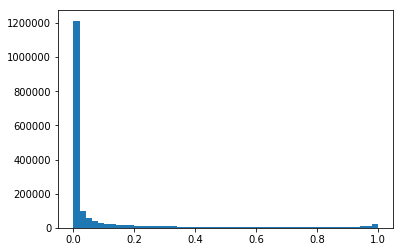

In [263]:
g=plt.hist(oof_ew, bins=50)

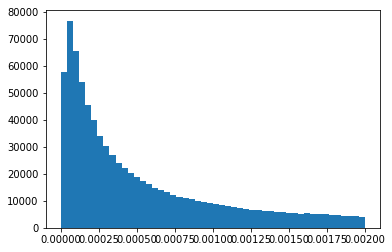

In [271]:
g=plt.hist(oof_ew, bins=50, range=(0, 0.002))

In [276]:
confident_mask = oof_ew < 0.2
weighted_auc, overall_auc, bias_df = get_various_auc(valid_df.iloc[confident_mask], oof_ew[confident_mask])
print(weighted_auc, overall_auc)
display(bias_df.describe().loc['min'])

0.8171897913001779 0.9078071203782822


bnsp_auc            0.922298
bpsn_auc            0.565713
subgroup_auc        0.715921
subgroup_size    2851.000000
Name: min, dtype: float64

In [255]:
oof_last = np.mean(seed_oof_train_last_list, axis=0)
loss = xentropy(valid_df[TOXICITY_COLUMN].values, oof_lastoof_ew)
print(f'loss: {loss}')
weighted_auc, overall_auc, bias_df = get_various_auc(valid_df, oof_last)
print(weighted_auc, overall_auc)
display(bias_df.describe().loc['min'])
weighted_auc_list.append(weighted_auc)

0.9294725548592615 0.9680522911567915


bnsp_auc            0.958033
bpsn_auc            0.841702
subgroup_auc        0.850958
subgroup_size    4889.000000
Name: min, dtype: float64

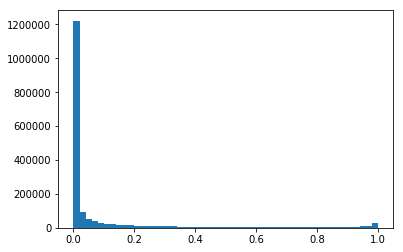

In [265]:
g=plt.hist(oof_last, bins=50)

In [301]:
def xentropy(y_true, y_pred):
    return - np.mean(y_true * np.log(y_pred + 1e-5))

In [302]:
xentropy(valid_df[TOXICITY_COLUMN].values, oof_last)

0.18164541744970353

(array([1.26514e+06, 2.87000e+02, 2.54000e+02, 2.60000e+02, 2.88000e+02,
        1.67680e+04, 7.54000e+02, 3.75900e+03, 1.38926e+05, 7.52000e+02,
        1.08044e+05, 6.94000e+02, 9.73000e+02, 1.02500e+03, 8.61000e+02,
        5.99740e+04, 1.12300e+03, 1.02400e+03, 1.42300e+03, 1.06900e+03,
        5.11640e+04, 1.43300e+03, 1.74500e+03, 1.50700e+03, 1.29300e+03,
        3.92650e+04, 2.04600e+03, 2.16400e+03, 2.49400e+03, 1.95500e+03,
        2.63450e+04, 2.82900e+03, 2.79500e+03, 2.95500e+03, 1.60350e+04,
        2.74100e+03, 3.24800e+03, 3.16300e+03, 3.03400e+03, 2.43400e+03,
        9.63700e+03, 5.87500e+03, 2.49100e+03, 2.01600e+03, 1.58600e+03,
        2.90500e+03, 9.32000e+02, 5.42000e+02, 2.93000e+02, 4.55400e+03]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.

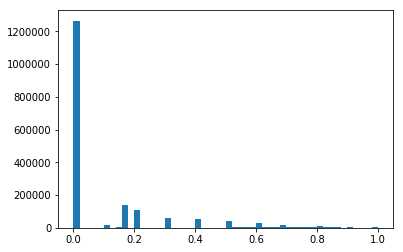

In [297]:
plt.hist(valid_df[TOXICITY_COLUMN].values, bins=50)